# HEART DISEASE PREDICTION USING RANDOM FOREST  

> **Objective:**  
Build a `Random Forest` classification model to predict heart disease using the Cleveland Clinical Dataset and evaluate its performance using key ML metrics.

## Introduction  

Machine Learning models — particularly tree-based methods like **Random Forest** — are powerful tools that identify patterns in patient data.

In this project, we will:  

- Perform EDA and preprocessing  
- Train a **Random Forest Classifier**  
- Tune hyperparameters (`n_estimators` and `max_depth`)  
- Evaluate using **Accuracy, Precision, Recall, ROC–AUC**  
- Analyze **Feature Importance**  


In [16]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


### Verifying Dataset Shape and Columns  
Before proceeding, we confirm the number of samples, number of features, and the exact column names directly from the dataset.


In [17]:
# Load dataset
df = pd.read_csv("Heart_disease_cleveland_new.csv")  # Change filename if needed
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


## Converting Numerical Gender Values to Labels

The dataset encodes gender as:
- `0` → female  
- `1` → male  

To make analyses and visualizations easier, we convert these numeric values into text labels.


In [18]:
# Convert sex values to numeric (in case they are strings)
df["sex"] = df["sex"].astype(int)

# Map 0/1 → female/male
#df["sex"] = df["sex"].map({0: "female", 1: "male"})

df["sex"].unique(), df.head()


(array([1, 0]),
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
 0   63    1   0       145   233    1        2      150      0      2.3      2   
 1   67    1   3       160   286    0        2      108      1      1.5      1   
 2   67    1   3       120   229    0        2      129      1      2.6      1   
 3   37    1   2       130   250    0        0      187      0      3.5      2   
 4   41    0   1       130   204    0        2      172      0      1.4      0   
 
    ca  thal  target  
 0   0     2       0  
 1   3     1       1  
 2   2     3       1  
 3   0     1       0  
 4   0     1       0  )

In [19]:
# Check number of samples (rows) and features (columns)
print("Dataset Shape:", df.shape)

# Display column names
print("\nColumn Names:")
print(df.columns.tolist())

# View data types
print("\nData Types:")
print(df.dtypes)


Dataset Shape: (303, 14)

Column Names:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Data Types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## Dataset Description  

We use the **Cleveland Heart Disease Dataset**, which contains **303 samples** and **14 attributes**.

### **Features Overview**

| Feature | Description |
|---------|-------------|
| age | Age of the patient |
| sex | Gender (1 = male, 0 = female) |
| cp | Chest pain type |
| trestbps | Resting blood pressure |
| chol | Serum cholesterol (mg/dl) |
| fbs | Fasting blood sugar (> 120 mg/dl) |
| restecg | Resting electrocardiographic results |
| thalach | Maximum heart rate achieved |
| exang | Exercise-induced angina |
| oldpeak | ST depression induced by exercise |
| slope | Slope of the peak exercise ST segment |
| ca | Number of major vessels colored by fluoroscopy |
| thal | Thalassemia |
| target | **1 = disease, 0 = no disease** |


> The **target variable** is binary — perfect for classification!


## Initial Data Exploration  

We inspect:  
- Shape of dataset  
- Missing values  
- Basic statistics  


In [20]:
print("Shape of Data:", df.shape)
print("\nMissing Values:\n")
print(df.isnull().sum())
print("Count of '?' values per column")
print((df=='?').sum())

df.describe()


Shape of Data: (303, 14)

Missing Values:

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Count of '?' values per column
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


# Exploratory Data Analysis (EDA)

We begin by visualizing the target distribution, gender distribution, how heart disease varies by gender, feature distributions, correlations, and outliers.


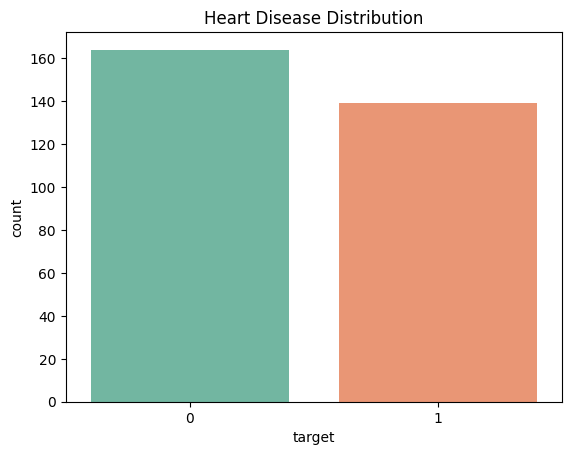

In [21]:
sns.countplot(x=df["target"], palette="Set2")
plt.title("Heart Disease Distribution")
plt.show()


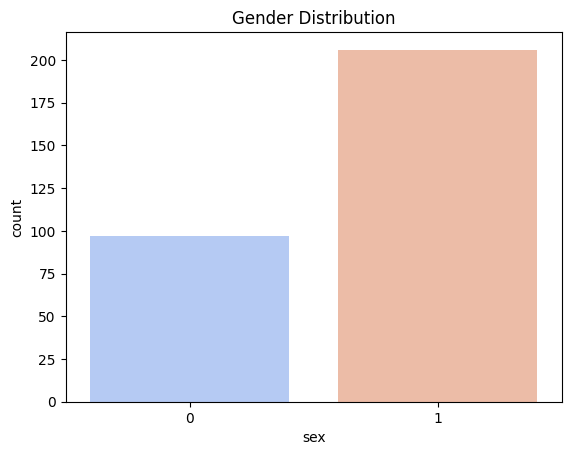

In [22]:
sns.countplot(x=df["sex"], palette="coolwarm")
plt.title("Gender Distribution")
plt.show()


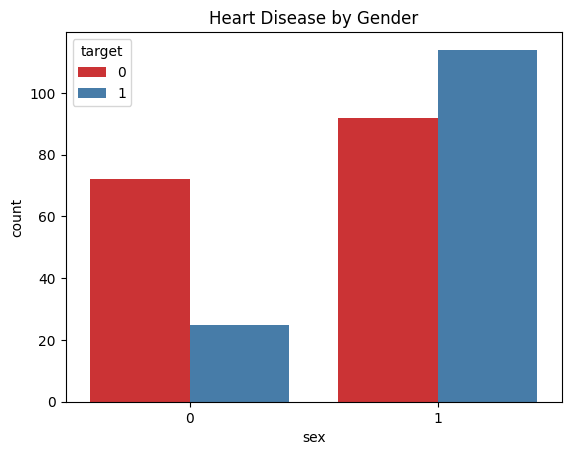

In [23]:
sns.countplot(x=df["sex"], hue=df["target"], palette="Set1")
plt.title("Heart Disease by Gender")
plt.show()


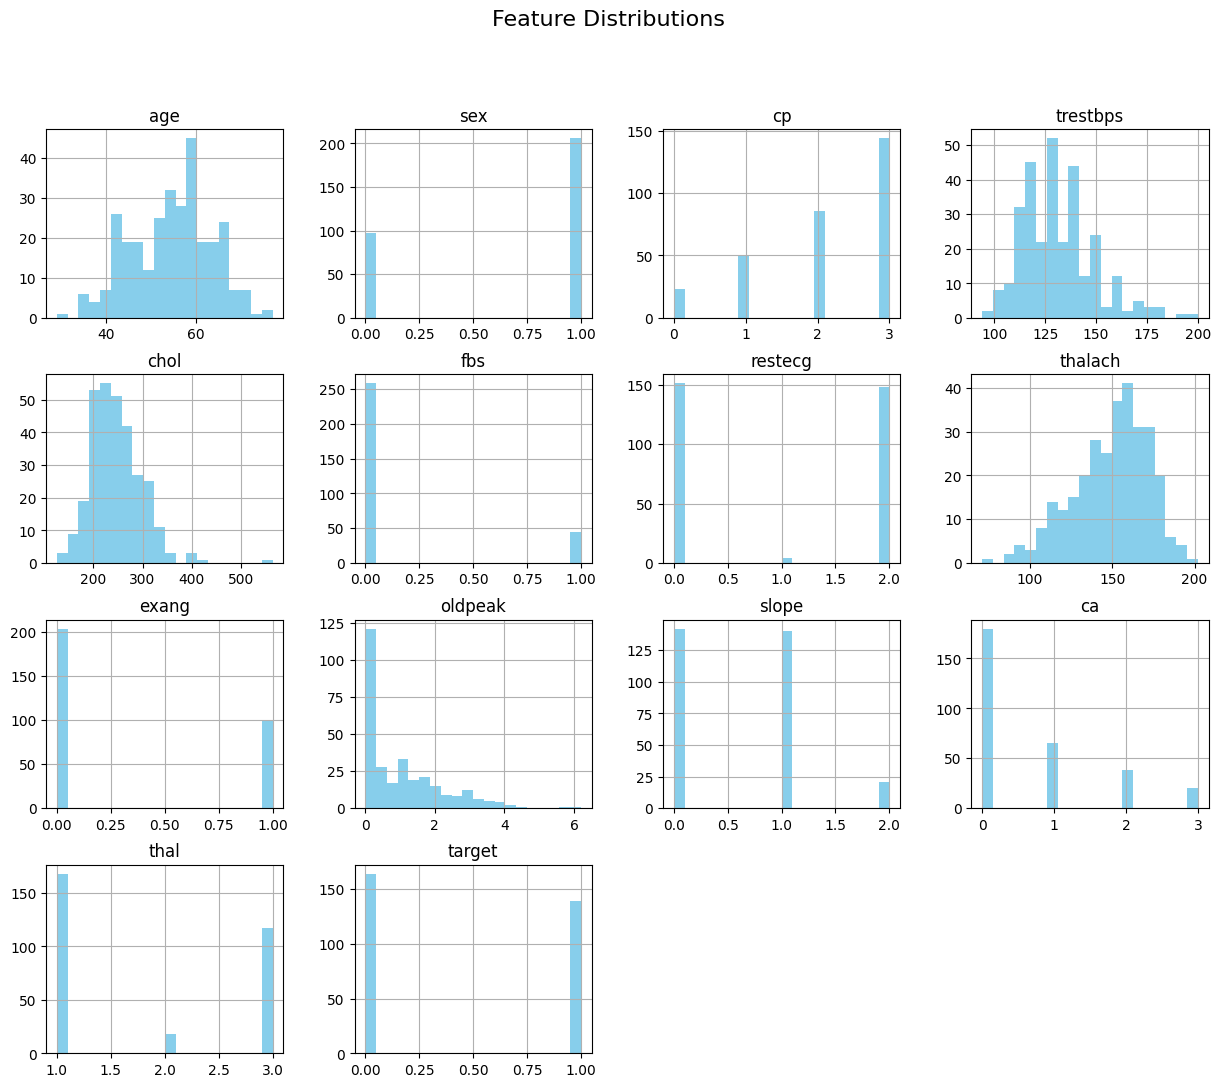

In [24]:
df.hist(figsize=(15, 12), bins=20, color="skyblue")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


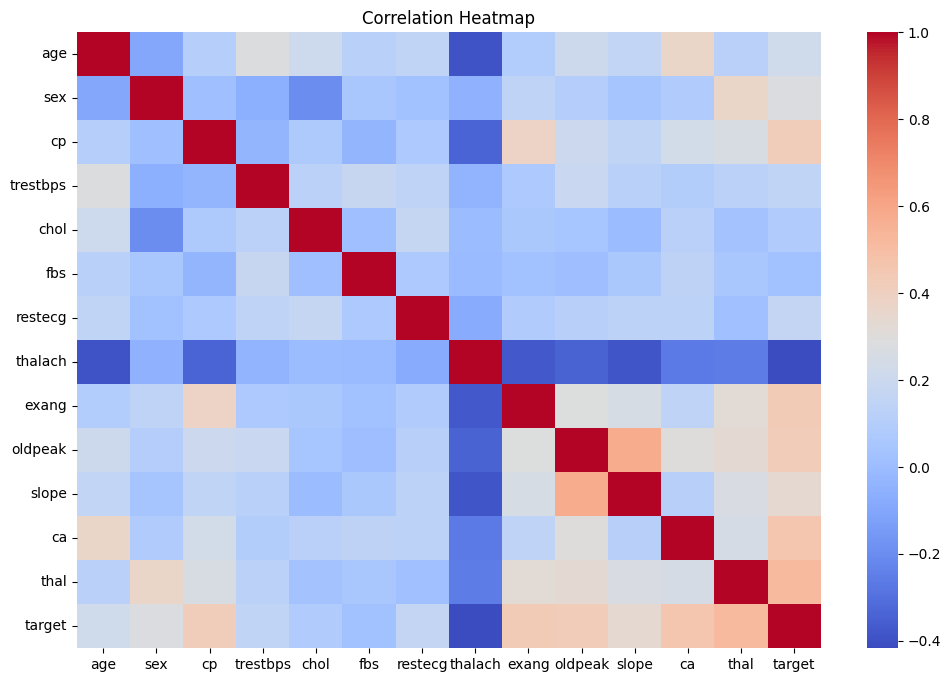

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include="number").corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


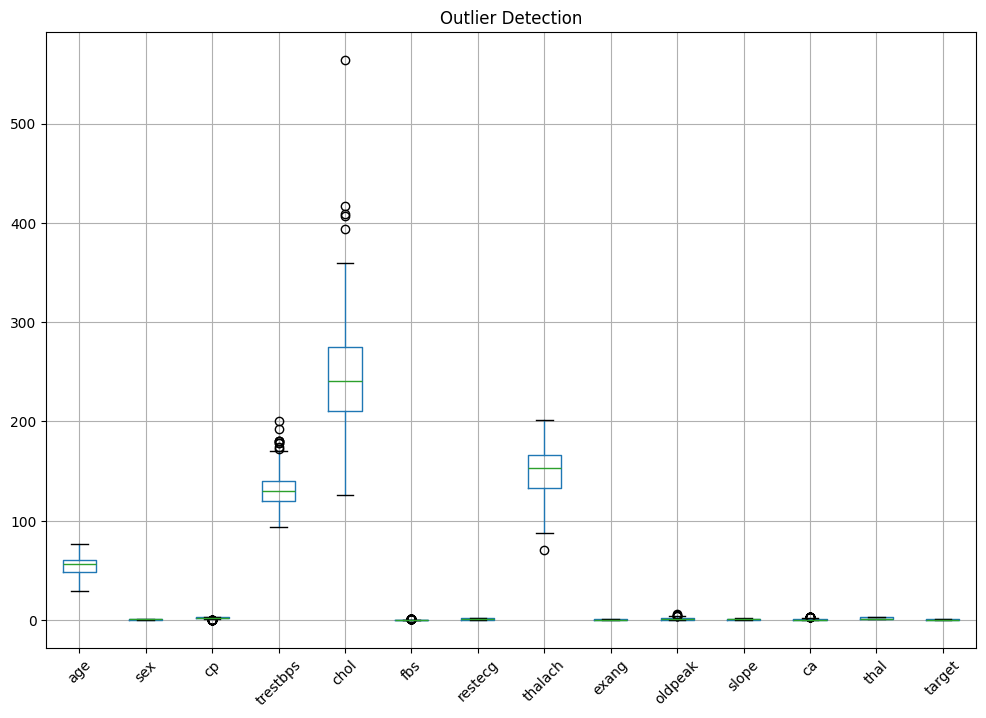

In [26]:
plt.figure(figsize=(12, 8))
df.select_dtypes(include="number").boxplot(rot=45)
plt.title("Outlier Detection")
plt.show()


## Outlier Removal (IQR Method)

Using the Interquartile Range (IQR) method, we remove extreme outliers from key numerical features to improve training quality.


In [27]:
def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[cols] < (Q1 - 1.5 * IQR)) | 
             (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df = remove_outliers(df, numeric_cols)

df.shape


(284, 14)

## One-Hot Encoding for Categorical Columns

We convert non-numeric categorical columns into dummy variables so that machine learning models can process them.


In [28]:
categorical_cols = ["sex", "cp", "restecg", "slope", "thal"]

f = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


## Data Preprocessing  

### Steps performed:
- Handle missing data  
- Split dataset into features and labels  
- Normalize numerical columns using **StandardScaler**  
- Create **train-test split (80–20)**  

> Good preprocessing ensures better model performance.


In [29]:
# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_test.shape


((227, 13), (57, 13))

## Feature Scaling  

We scale numerical features using **StandardScaler** so all values are on a similar range.  


In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Random Forest Model  

We begin by training a default Random Forest model to observe baseline performance.


In [31]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 0.8771929824561403
Precision: 0.8333333333333334
Recall: 0.8695652173913043
ROC-AUC: 0.8759590792838874


## Hyperparameter Tuning  

We tune **two important parameters**:  
- `n_estimators` → number of trees  
- `max_depth` → depth of each tree  

Using **GridSearchCV (5-fold cross-validation)** ensures better generalization.


In [32]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 5, 10, 15]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_


Best Parameters: {'max_depth': 10, 'n_estimators': 100}


## Model Evaluation  

We evaluate performance using:  
- Accuracy  
- Precision  
- Recall  
- ROC–AUC  
- Confusion Matrix  
- Classification Report  


In [33]:
y_pred_best = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))


Accuracy: 0.8771929824561403
Precision: 0.8333333333333334
Recall: 0.8695652173913043
ROC-AUC: 0.9418158567774937

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        34
           1       0.83      0.87      0.85        23

    accuracy                           0.88        57
   macro avg       0.87      0.88      0.87        57
weighted avg       0.88      0.88      0.88        57



## Confusion Matrix  


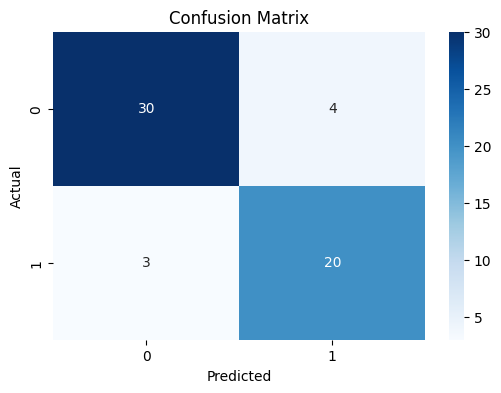

In [34]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ROC Curve  


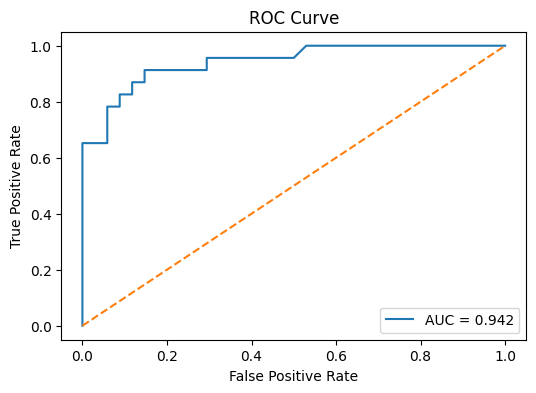

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Feature Importance Analysis  

We analyze which input features affect the model’s prediction the most.


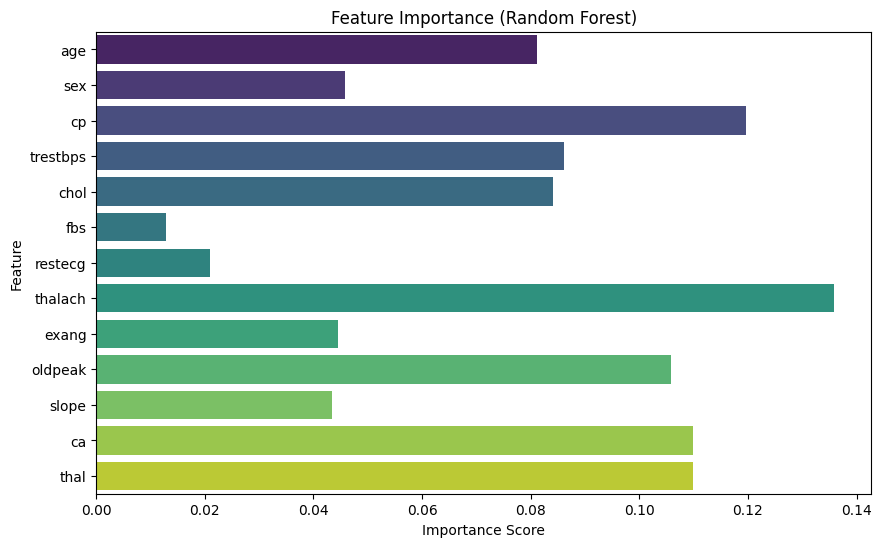

In [36]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Conclusion  

> **Random Forest achieved strong performance**  
> using medical attributes to predict heart disease.

### Key Takeaways:
- Hyperparameter tuning improved performance  
- ROC–AUC indicates the model is reliable  
- Important features include:  
  - **cp (chest pain type)**  
  - **thalach**  
  - **oldpeak**  
  - **ca**  
  - **thal**

### Final Statement  
The model is accurate, interpretable, and useful for clinical decision-support applications.

---


## Saving the Trained Model and Scaler

To deploy our Heart Disease Prediction system in a web application (Streamlit),
we need to export the trained **Random Forest model** and the **StandardScaler** used for feature scaling.

These two files will be loaded directly by the Streamlit app to ensure:
- Consistent preprocessing  
- Accurate predictions  
- Reproducible results  

The following code saves the model and scaler as `.pkl` files that can be reused outside this notebook.


In [37]:
import pickle

pickle.dump(best_model, open("best_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

print("Model and Scaler saved!")


Model and Scaler saved!


In [38]:
print(list(X.columns))


['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
